In [46]:
import pandas as pd
import numpy as np

import keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, optimizers, layers
from keras.preprocessing import text, sequence
from keras.utils import plot_model

!pip install -q -U keras-tuner
import kerastuner as kt

import IPython


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from gensim.models import word2vec

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import sys
sys.path.append("../..")


from src.model_evaluation import *
from src.data_preprocessing import *

sns.set(context = 'notebook', style = 'whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# For Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

#### Define Callbacks

In [48]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc')

# Data Preprocessing 

In [49]:
#for colab
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flatiron_project_4/combined.csv')
df = pd.read_csv('../../data/targeted_combined.csv')
df.shape

(22606, 2)

In [50]:
sequence_len = 128

X = df['txt_cleaned']
y = df['emotion']

tokenizer = text.Tokenizer()


#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)

#tokenize full X_train
tokenizer.fit_on_texts(list(X))
list_tokenized_X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(list_tokenized_X_train, maxlen=128)

#Tokenize training X
tokenized_X_t = tokenizer.texts_to_sequences(X_t)
X_t = sequence.pad_sequences(tokenized_X_t, maxlen=128)

#Tokenize validation
tokenized_X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(tokenized_X_val, maxlen=128)

#Tokenize hold out set
tokenized_X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_X_test, maxlen=128)

## Model 1
RNN First Simple Model

In [51]:
def make_model1():
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model.add(LSTM(25, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

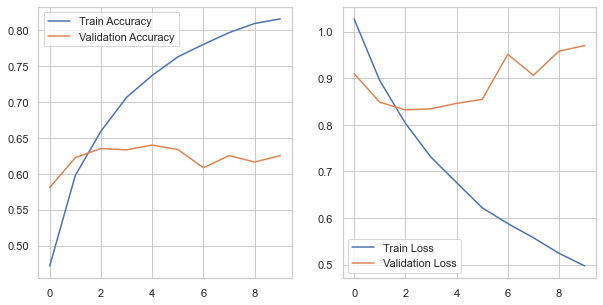

In [52]:
model1 = make_model1() 
history = model1.fit(X_t,y_t,
            epochs = 10,
            batch_size = 50, 
            validation_data = (X_val,y_val),
            #callbacks = [earlystopping],
            verbose = 0)
graph_model_history(history)


Statistics for Model1, LSTM


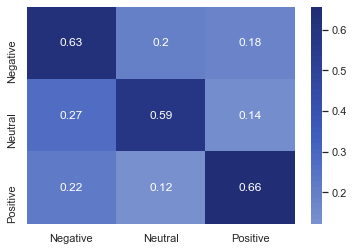

model validation accuracy is: 0.6253833451285681


In [53]:
y_pred = model1.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val,y_pred)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 1 Evaluation
Model 1 overfits after 2 epochs.  It reaches a 62% accuracy with over 50% in each category.  It is strong in identifying positive emotions, but less so for negative and neutral emotions.  

# Model 2
In this model we will try using GloVe embeddings instead of a learned embedding layer
Relying heavily on fchollet at https://keras.io/examples/nlp/pretrained_word_embeddings/

This is beneficial because the embedding layer makes up a majority of our trainable parameters, and using pretrained weights both leverages the wortk of others, and makes our models train faster with less computational overhead.

We will need to preprocess our data a little differently for this, so we create new versions of the train, validation, and test sets and preprocess differently to prepare to create a custom weight set to use to initialize our embedding layer.  This includes creating an index of our vocabulary, looking up the GloVe embedding values for those words, and turning those into a matrix of our weights.

We then have newly encoded datasets, which we mark with the _glove ending, and a set of weights, `embedding_matrix` to use to initialize pretrained embedding layers.


If you want to run this next cell, you need to download the glove.6b file below.  It is very large and will take a long.  I recommend skipping this.  

That said you can download it [here](http://nlp.stanford.edu/data/glove.6B.zip).
just extract the file `glove.6B.50d.txt` into the folder with this notebook.

In [54]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t_2, X_val_2, y_t, y_val = train_test_split(X_train_2, y_train, random_state = 42, test_size = 0.25)

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(X)
vectorizer.adapt(text_ds)
total_vocabulary = set(vectorizer.get_vocabulary())

print(f'total vocabulary length: {len(total_vocabulary)}')
word_index = dict(zip(total_vocabulary, range(len(total_vocabulary))))



glove = {}
with open('glove.6B.50d.txt',
          'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype = np.float32)
            glove[word] = vector


num_tokens = len(total_vocabulary) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits +=1
    else:
        misses += 1
print(f'converted {hits} words ({misses} misses)')
    

X_t_glove = vectorizer(np.array([[s] for s in X_t_2])).numpy()
X_val_glove = vectorizer(np.array([[s] for s in X_val_2])).numpy()
X_test_glove = vectorizer(np.array([[s] for s in X_test_2])).numpy()
X_train_glove = vectorizer(np.array([[s] for s in X_train_2])).numpy()

total vocabulary length: 17877
converted 10811 words (7066 misses)


That's a lot of words that did not get encoded, 7070 of 17883

In [55]:
def make_model2():

    model = Sequential()

    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = False
                                )
    model.add(embedding_layer)
    model.add(LSTM(50, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

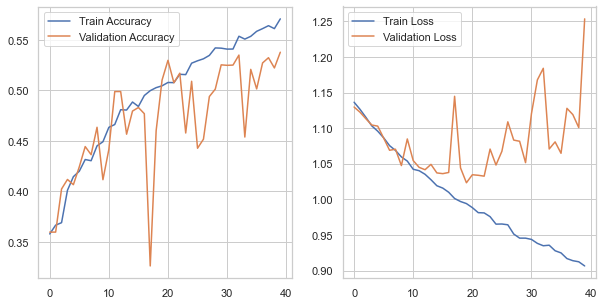

In [56]:
model2 = make_model2()
history = model2.fit(X_t_glove, y_t, 
                     epochs = 40, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val),
                     verbose = 0,
                     #callbacks = [earlystopping]
                     )

graph_model_history(history)

Statistics for Model2, LSTM


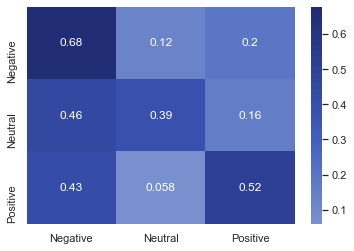

model validation accuracy is: 0.537862703467799


In [57]:

y_pred = model2.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1)
print('Statistics for Model2, LSTM')
plot_confusion_matrix(y_val, y_pred)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

## Model 2 Evaluation
Model 2 performed worse than model 1 and was more confused about neutral tweets.  I think the un-embeddable words are hurting performance.

### Model 3
with this model we will continue to use the GloVe embeddings, but allow them to be trained, and add regularization to improve try to improve validation accuracy.

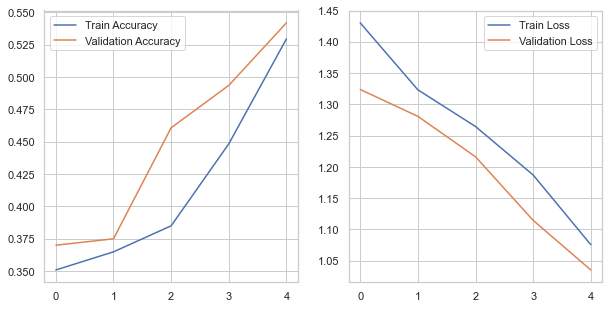

In [81]:
def make_model3():
    model = Sequential()

    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = True
                                )
    model.add(embedding_layer)
    model.add(LSTM(75, 
                   return_sequences=True
                   ))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))
 
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

model3 = make_model3()
history = model3.fit(X_t_glove, y_t, 
                     epochs = 5, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val),
                     verbose = 0,
                     callbacks = [earlystopping]
                     )
graph_model_history(history)


Statistics for Model3, LSTM


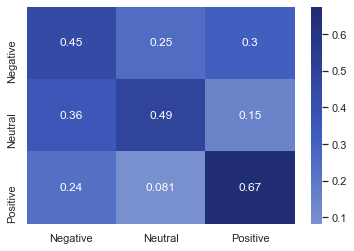

model validation accuracy is: 0.5418730832743571


In [82]:

y_pred = model3.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1)
print('Statistics for Model3, LSTM')
plot_confusion_matrix(y_val, y_pred)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

### Model 3 Evaluation
GloVe embeddings continue to disappoint.  We are going to abandon this approach.

#### Model 4:
So far we have not seen a benefit from using pretrained embeddings, nor using larger, more complex models.  Our simplest model continues to perform the best.  For that reason I will try to create an even simpler model.  Perhaps that is the key.  However, I would like to try making my LSTM layer bidirectional.  This means that it will read the input both front to back and back to front.  With only 5 units, however will will only remember the previous (and next) 5 terms in the tweet.

In [63]:
def make_model4():
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model.add(Bidirectional(LSTM(units=5, 
                                 return_sequences=True, 
                                 dropout=0.2,
                                 recurrent_regularizer = regularizers.l1_l2(l1=1e-2,l2=1e-2)
                                 )))
    model.add(GlobalMaxPool1D())
    model.add(Dense(5, activation='relu',
              kernel_regularizer = regularizers.l1_l2(l1=1e-3,l2=1e-3)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

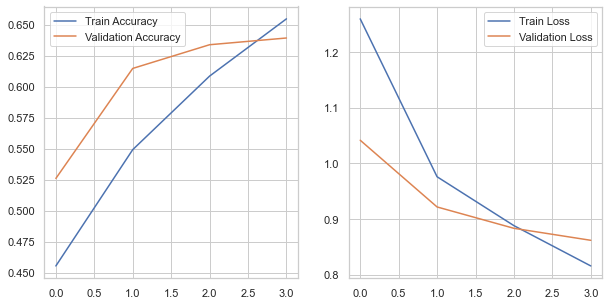

In [77]:
model4 =  make_model4()

history = model4.fit(X_t, y_t,
                     epochs = 4,
                     batch_size = 50,
                     validation_data = (X_val,y_val),
                     verbose = 0)

graph_model_history(history)


Statistics for Model5, LSTM


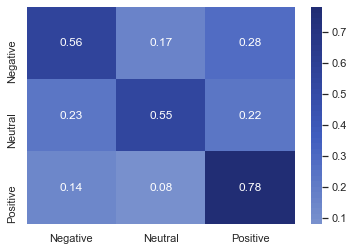

model validation accuracy is: 0.6350554376032083


In [70]:
y_pred = model4.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)
print('Statistics for Model4, LSTM')
plot_confusion_matrix(y_val,y_pred)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 4 evaluation
Model 4 has performed quite well.  It is especially successful in predicting positive and negative tweets, and reasonably good at predicting neutral tweets, thought is does mistake them for negative sometimes.  I think it may be that simpler is better, and that the bidirectional LSTM has been helpful.

Let's train the model on the full train set and test it on the testing holdout set for final metrics.

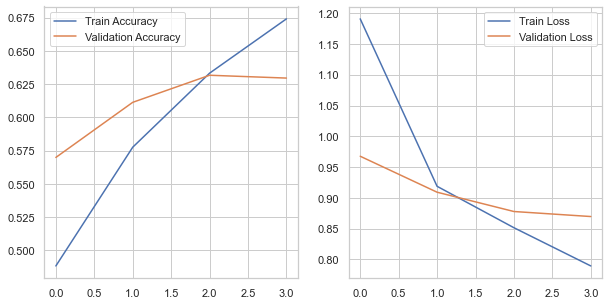

In [73]:
final_model =  make_model4()

history = final_model.fit(X_train, y_train,
                     epochs = 4,
                     batch_size = 50,
                     validation_data = (X_test,y_test),
                     verbose = 0)

graph_model_history(history)

Statistics for final_fodel on holdout set, LSTM


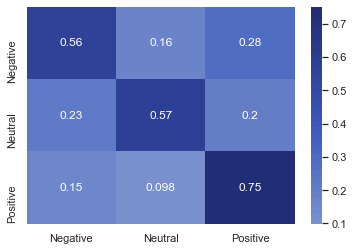

final model accuracy on the holdout set is: 0.6295116772823779


In [83]:
y_pred = final_model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print('Statistics for final_fodel on holdout set, LSTM')
plot_confusion_matrix(y_test,y_pred)
print(f'final model accuracy on the holdout set is: {accuracy_score(y_test,y_pred)}')

# Summary:
We tried many tricks to improve the accuracy of our model, but in the end, a small model with plenty of regularization gave us the best results.  Our model consistently achieves over 64% accuracy on predicting the sentiments of a tweet for a given product, and is particularly good at identifying positive and negative tweets, with near 70% accuracy on each.